In [6]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim


In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

transform = transforms.Compose(
    [transforms.ToTensor(),
    # transforms.Resize((28,28)),
    # transforms.Grayscale(),
    transforms.Normalize(0.5, 0.5)])

batch_size = 1

trainset = datasets.MNIST(root='./data', train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)

testset = datasets.MNIST(root='./data', train=False, transform=transform)
testloader = DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

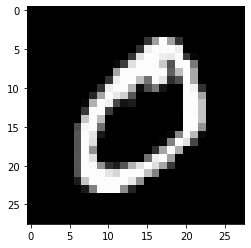

Classe esperada: 0


In [8]:
def showImage(image, label):
    fig = plt.figure
    plt.imshow(image.squeeze(), cmap='gray')
    plt.show()
    print(f'Classe esperada: {label}')

# pick a sample to plot
sample = 1
showImage(*trainset[sample]) # plot the sample


In [9]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 64) # input layer
        self.fc2 = nn.Linear(64, 64) # hidden layer
        self.fc3 = nn.Linear(64, 10) # output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, debug=False):
        # prepara imagem
        if debug: print(f'Input shape before flatten: {x.shape}')
        # x = torch.flatten(x)
        x = x.view(x.shape[0], -1)
        if debug: print(f'Input shape after flatten: {x.shape}')

        # define sequencia do forward
        x = torch.sigmoid(self.fc1(x)) # passa pela input layer
        x = torch.sigmoid(self.fc2(x)) # passa pela hidden layer
        x = torch.sigmoid(self.fc3(x)) # passa pela output layer
        return x

NeuralNet(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (sigmoid): Sigmoid()
)


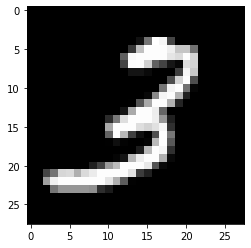

Classe esperada: 3


In [10]:
net = NeuralNet().to(device)
print(net)

index = np.random.randint(low=0, high=len(trainset))
test_image = trainset[index]
output = net(test_image[0].to(device))

# print(f'Output:\t{output}\n')

showImage(*test_image)
# print(f'Classe prevista: {output.argmax()}')

In [11]:
epochs = 10
lr = .003

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr)

In [ ]:
# # loop de treino
for epoch in range(epochs):
    total_loss = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        y_hat = net(inputs)
        loss = loss_fn(y_hat, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if i % 20000 == 0 and i > 0:
            print(f"[{epoch+1}, {i:5d}] Accumulated Loss: {total_loss/(20000*i)}")

    print(f"Loss: {total_loss / len(trainloader)} - Epoch: {epoch + 1}")

[1, 20000] Accumulated Loss: 9.173764232575894e-05
[1, 40000] Accumulated Loss: 9.020386772930622e-05
Loss: 1.7858361708601316 - Epoch: 1


In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy"
            f" {float(num_correct) / float(num_samples) * 100:.2f}"
        )

    model.train()
check_accuracy(trainloader, net)
check_accuracy(testloader, net)